,latent_dim,bits,compression,raw_ppl,kv_ppl,ae_ppl,kv_rel,ae_rel,lb_base,lb_comp,lb_rel
0,8,2,64.0,76.2,1292.5,1082.4,16.96,14.20,261.0,2000.6,7.66
1,8,4,32.0,76.2,104.4,640.4,1.37,8.40,261.0,1995.1,7.64
2,8,8,16.0,76.2,76.3,643.4,1.00,8.44,261.0,1940.4,7.43
3,8,16,8.0,76.2,76.2,657.7,1.00,8.63,261.0,1941.3,7.44
4,16,2,32.0,76.2,1310.4,1035.4,17.20,13.59,260.8,2573.5,9.87
5,16,4,16.0,76.2,104.0,474.0,1.37,6.22,260.8,1226.9,4.70
6,16,8,8.0,76.2,76.3,425.1,1.00,5.58,260.8,1087.5,4.17
7,16,16,4.0,76.2,76.2,429.5,1.00,5.64,260.8,1089.8,4.18
8,32,2,16.0,76.2,1310.4,1137.3,17.20,14.93,260.8,1756.9,6.74
9,32,4,8.0,76.2,104.1,250.3,1.37,3.28,260.8,738.0,2.83



LaTeX table code:

\begin{table}
\caption{Perplexity degradation and compression ratios for distilGPT‑2 KV‑cache compression.}
\label{tab:compression_results}
\begin{tabular}{rrrrrrrl}
\toprule
latent_dim & bits & compression & kv_rel & ae_rel & lb_base & lb_comp & lb_rel \\
\midrule
8 & 2 & 64.00 & 16.96 & 14.20 & 261.03 & 2000.57 & 7.66 \\
8 & 4 & 32.00 & 1.37 & 8.40 & 261.03 & 1995.11 & 7.64 \\
8 & 8 & 16.00 & 1.00 & 8.44 & 261.03 & 1940.35 & 7.43 \\
8 & 16 & 8.00 & 1.00 & 8.63 & 261.03 & 1941.29 & 7.44 \\
16 & 2 & 32.00 & 17.20 & 13.59 & 260.84 & 2573.47 & 9.87 \\
16 & 4 & 16.00 & 1.37 & 6.22 & 260.84 & 1226.88 & 4.70 \\
16 & 8 & 8.00 & 1.00 & 5.58 & 260.84 & 1087.50 & 4.17 \\
16 & 16 & 4.00 & 1.00 & 5.64 & 260.84 & 1089.81 & 4.18 \\
32 & 2 & 16.00 & 17.20 & 14.93 & 260.84 & 1756.86 & 6.74 \\
32 & 4 & 8.00 & 1.37 & 3.28 & 260.84 & 737.96 & 2.83 \\
32 & 8 & 4.00 & 1.00 & 2.58 & 260.84 & 603.35 & 2.31 \\
32 & 16 & 2.00 & 1.00 & 2.60 & 260.84 & 602.35 & 2.31 \\
\bottomrule
\end{tabul

/var/folders/h8/8z2sfwhs7jnb1_3vtp670q480000gn/T/ipykernel_91489/4235159599.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,4))


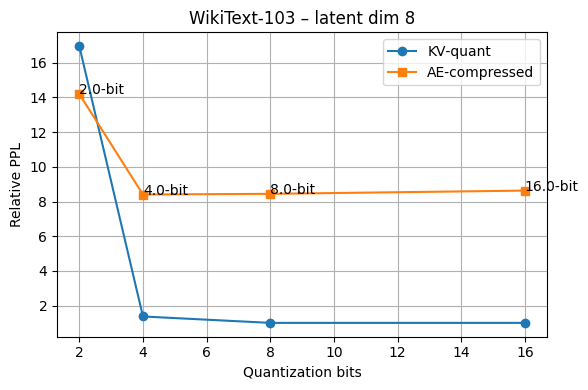

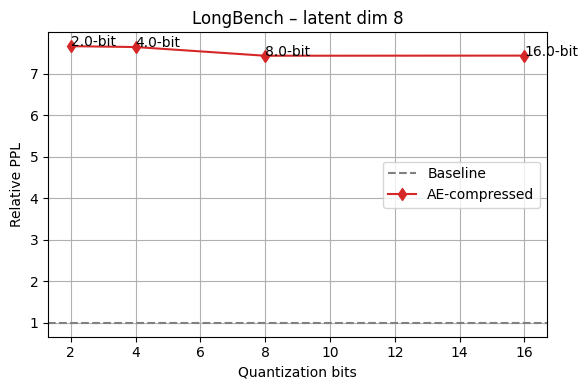

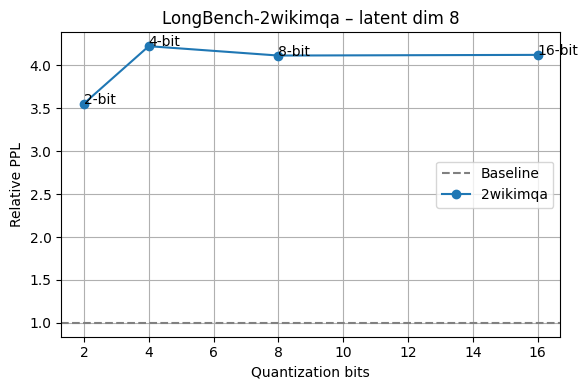

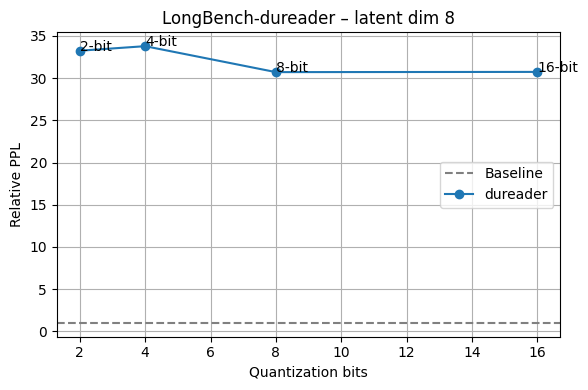

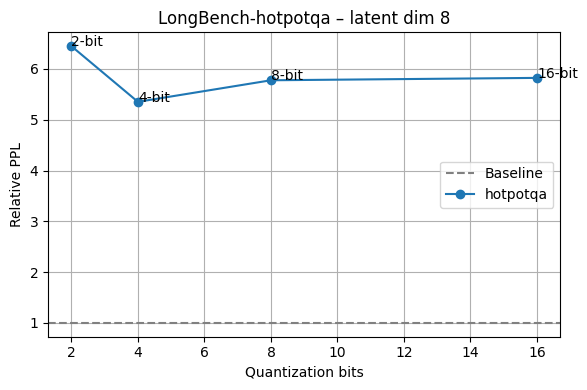

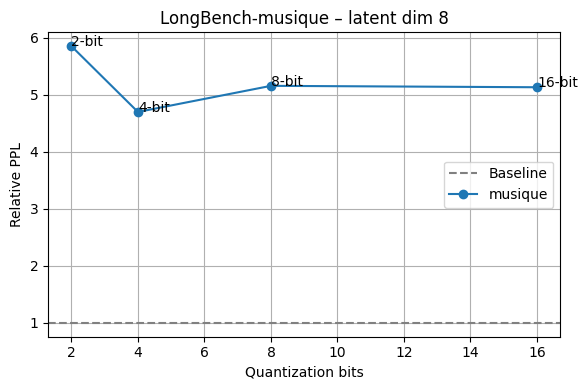

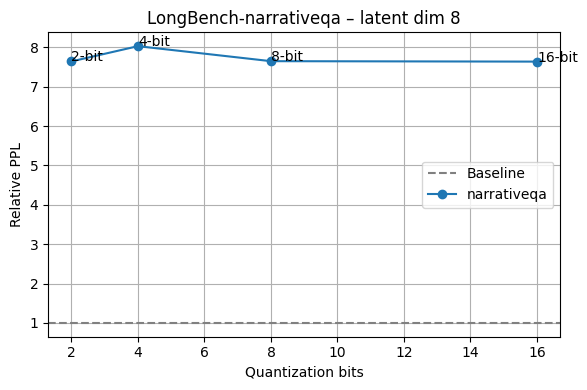

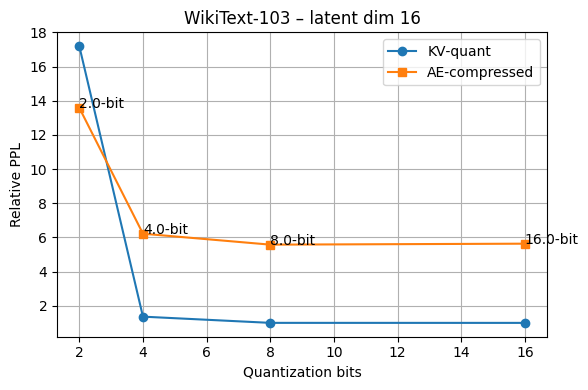

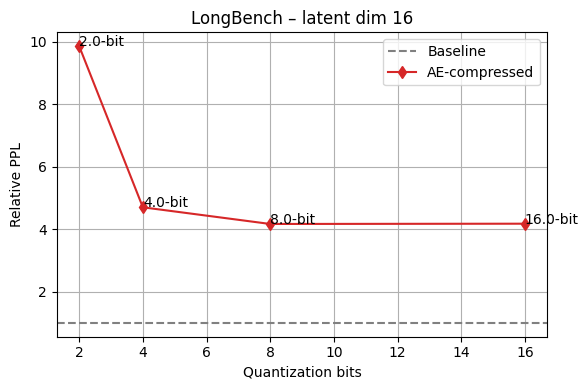

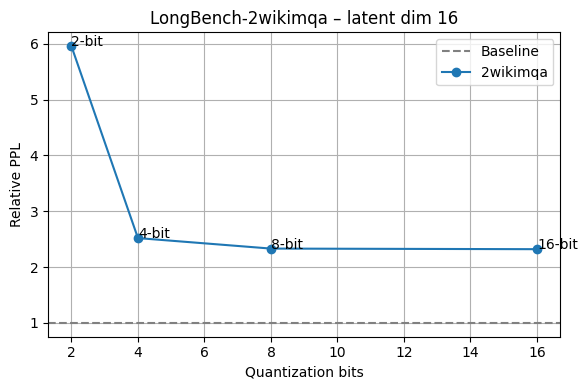

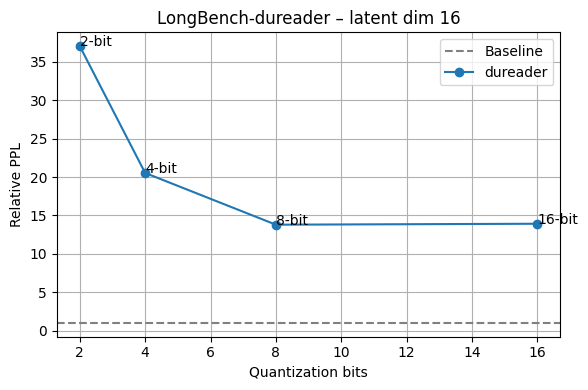

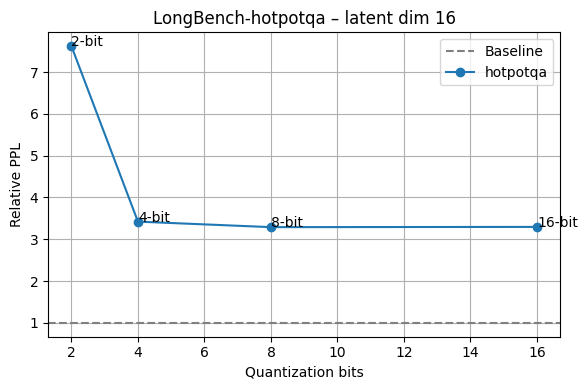

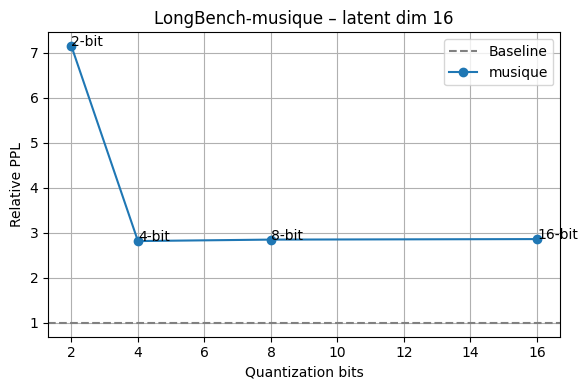

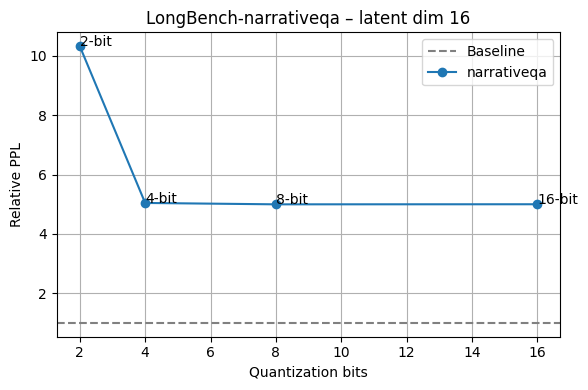

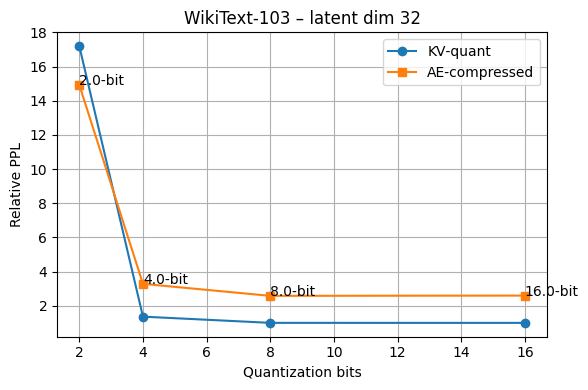

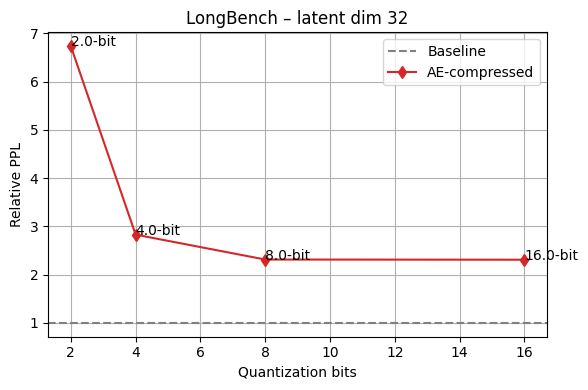

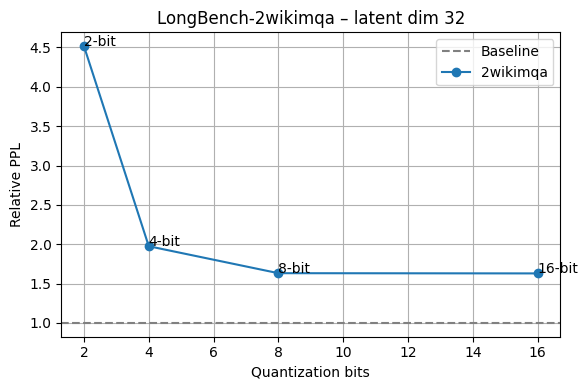

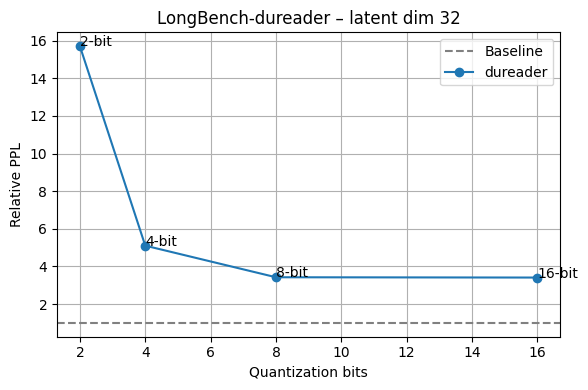

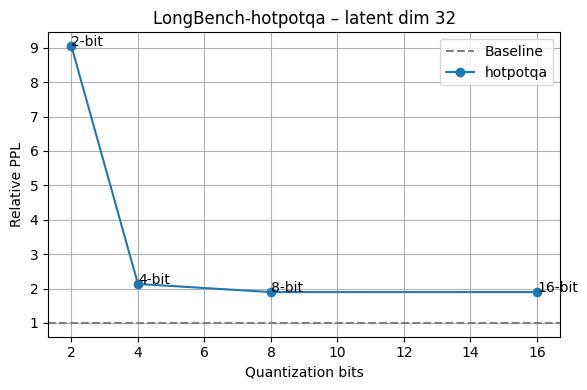

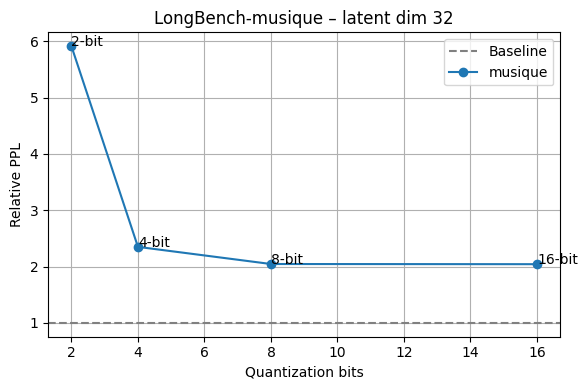

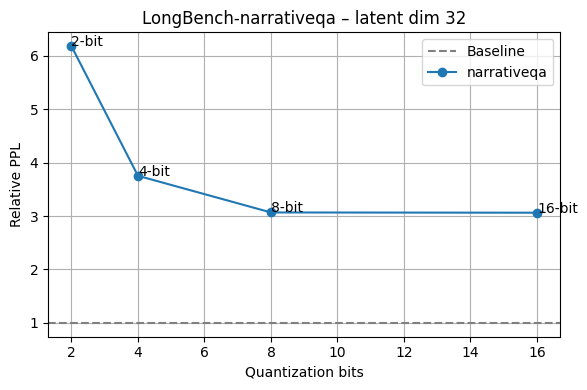

In [3]:
# KV‑cache compression analysis (open‑source only)
# ------------------------------------------------
import json, glob, re, statistics, itertools
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# 1) locate result files in the current directory
files = glob.glob("benchmark_results-latent-*.json")
if not files:
    raise FileNotFoundError("No benchmark_results‑latent‑*.json files in this folder!")

records, task_records = [], []   # ← second list collects per‑task rows

for path in files:
    latent_dim = int(re.search(r"latent-(\d+)", path).group(1))
    with open(path) as fp:
        res = json.load(fp)

    raw_ppl       = res["raw_baseline_ppl"]
    lb_baselines  = res["longbench"]["baseline"]            # dict task→PPL
    lb_base_avg   = statistics.mean(lb_baselines.values())

    for bits_str, vals in res["perplexities"].items():
        bits        = int(bits_str)
        kv_ppl      = vals["kv_cache_baseline_ppl"]
        ae_ppl      = vals["ae_compressed_ppl"]
        lb_compressed = res["longbench"]["compressed"][bits_str]
        lb_comp_avg  = statistics.mean(lb_compressed.values())

        comp_ratio = (64 / latent_dim) * (16 / bits)  # original 64‑d @ 16‑bit → new

        # overall‑average row
        records.append(dict(
            latent_dim = latent_dim,
            bits       = bits,
            compression= comp_ratio,
            raw_ppl    = raw_ppl,
            kv_ppl     = kv_ppl,
            ae_ppl     = ae_ppl,
            kv_rel     = kv_ppl / raw_ppl,
            ae_rel     = ae_ppl / raw_ppl,
            lb_base    = lb_base_avg,
            lb_comp    = lb_comp_avg,
            lb_rel     = lb_comp_avg / lb_base_avg
        ))

        # per‑task rows
        for task, base_ppl in lb_baselines.items():
            comp_ppl = lb_compressed[task]
            task_records.append(dict(
                latent_dim = latent_dim,
                task       = task,
                bits       = bits,
                lb_rel     = comp_ppl / base_ppl
            ))

# --- tidy dataframes ------------------------------------------------------
df        = pd.DataFrame(records ).sort_values(["latent_dim","bits"]).reset_index(drop=True)
df_tasks  = pd.DataFrame(task_records).sort_values(["latent_dim","task","bits"]).reset_index(drop=True)

# 2) interactive dataframe of the summary rows
display(df.style.format({
    "compression":"{:.1f}",
    "raw_ppl":"{:.1f}",
    "kv_ppl":"{:.1f}",
    "ae_ppl":"{:.1f}",
    "kv_rel":"{:.2f}",
    "ae_rel":"{:.2f}",
    "lb_base":"{:.1f}",
    "lb_comp":"{:.1f}",
    "lb_rel":"{:.2f}"
}))

# 3) LaTeX table of the summary rows
latex = df[["latent_dim","bits","compression",
            "kv_rel","ae_rel","lb_base","lb_comp","lb_rel"]].to_latex(
            index=False, float_format="%.2f",
            caption="Perplexity degradation and compression ratios for distilGPT‑2 KV‑cache compression.",
            label="tab:compression_results",
            column_format="rrrrrrrl")
print("\nLaTeX table code:\n")
print(latex)

# 4) figures ----------------------------------------------------------------
for latent in sorted(df["latent_dim"].unique()):
    sub = df[df["latent_dim"] == latent]

    # 4‑a) WikiText‑103 relative PPL
    plt.figure(figsize=(6,4))
    plt.plot(sub["bits"], sub["kv_rel"], "o-", label="KV‑quant")
    plt.plot(sub["bits"], sub["ae_rel"], "s-", label="AE‑compressed")
    for _, r in sub.iterrows():
        plt.annotate(f"{r.bits}‑bit", (r.bits, r.ae_rel))
    plt.xlabel("Quantization bits")
    plt.ylabel("Relative PPL")
    plt.title(f"WikiText‑103 – latent dim {latent}")
    plt.grid(True, which="both"); plt.legend(); plt.tight_layout()
    plt.savefig(f"WikiText‑103 – latent dim {latent}.png")

    # 4‑b) LongBench *average* relative PPL
    plt.figure(figsize=(6,4))
    plt.axhline(1.0, ls="--", color="gray", label="Baseline")
    plt.plot(sub["bits"], sub["lb_rel"], "d-", color="tab:red", label="AE‑compressed")
    for _, r in sub.iterrows():
        plt.annotate(f"{r.bits}‑bit", (r.bits, r.lb_rel))
    plt.xlabel("Quantization bits")
    plt.ylabel("Relative PPL")
    plt.title(f"LongBench – latent dim {latent}")
    plt.grid(True, which="both"); plt.legend(); plt.tight_layout()
    plt.savefig(f"LongBench – latent dim {latent}.png")

    # 4‑c) LongBench *per‑task* relative PPL
    tasks = df_tasks[df_tasks["latent_dim"] == latent]["task"].unique()
    for task in tasks:
        st = df_tasks[(df_tasks["latent_dim"] == latent) & (df_tasks["task"] == task)]
        plt.figure(figsize=(6,4))
        plt.axhline(1.0, ls="--", color="gray", label="Baseline")
        plt.plot(st["bits"], st["lb_rel"], "o-", label=f"{task}")
        for _, r in st.iterrows():
            plt.annotate(f"{r.bits}‑bit", (r.bits, r.lb_rel))
        plt.xlabel("Quantization bits")
        plt.ylabel("Relative PPL")
        plt.title(f"LongBench‑{task} – latent dim {latent}")
        plt.grid(True, which="both"); plt.legend(); plt.tight_layout()
        plt.savefig(f"LongBench‑{task} – latent dim {latent}.png")